# Mask R-CNN

This notebooks shows an example for training Mask R-CNN for deadwood *object detection* or *instance segmentation*.

In [ ]:
from pathlib import Path
import sys
absolute_path = Path().absolute()
sys.path.append(str(absolute_path.parents[0]))
from drone_detector.utils import *

from icevision.all import *

# Read and parse data

In [ ]:
parser = parsers.COCOMaskParser('../data/analysis_data/coco.json', img_dir='../data/analysis_data/raster_tiles/')
class_map = ClassMap(['Standing deadwood', 'Fallen deadwood'])

In [ ]:
train, valid = parser.parse()

# Set augmentations, datasets and dataloaders

`tfms.A.aug_tfms` includes various common augmentations, such as rotations, flips and random crops, as well as brightness and contrast augmenting.

In [ ]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=(400,400)), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train, train_tfms)
valid_ds = Dataset(valid, valid_tfms)

In [ ]:
train_dl = mask_rcnn.train_dl(train_ds, batch_size=16, shuffle=True, num_workers=4)
valid_dl = mask_rcnn.valid_dl(valid_ds, batch_size=16, shuffle=False, num_workers=4)

# Init model

We use Mask R-CNN with pretrained ResNet50-backbone. IceVision provides easy ways to do this.

In [ ]:
model = mask_rcnn.model(num_classes=len(class_map))

Make a fastai learner

In [ ]:
learn = mask_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model)

Search for optimal learning rate for fine_tune

SuggestedLRs(lr_min=0.0001737800776027143, lr_steep=1.0964781722577754e-06)

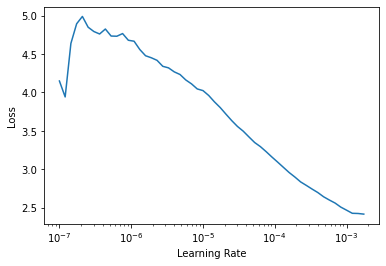

In [ ]:
learn.lr_find()

# Train model

Train model quickly with 3e-3 as the maximum learning rate.

In [ ]:
learn.fine_tune(10, 3e-3, freeze_epochs=1)

# See results

In [ ]:
infer_dl = mask_rcnn.infer_dl(valid_ds, batch_size=8)
samples, preds = mask_rcnn.predict_dl(model, infer_dl)

  0%|          | 0/21 [00:00<?, ?it/s]

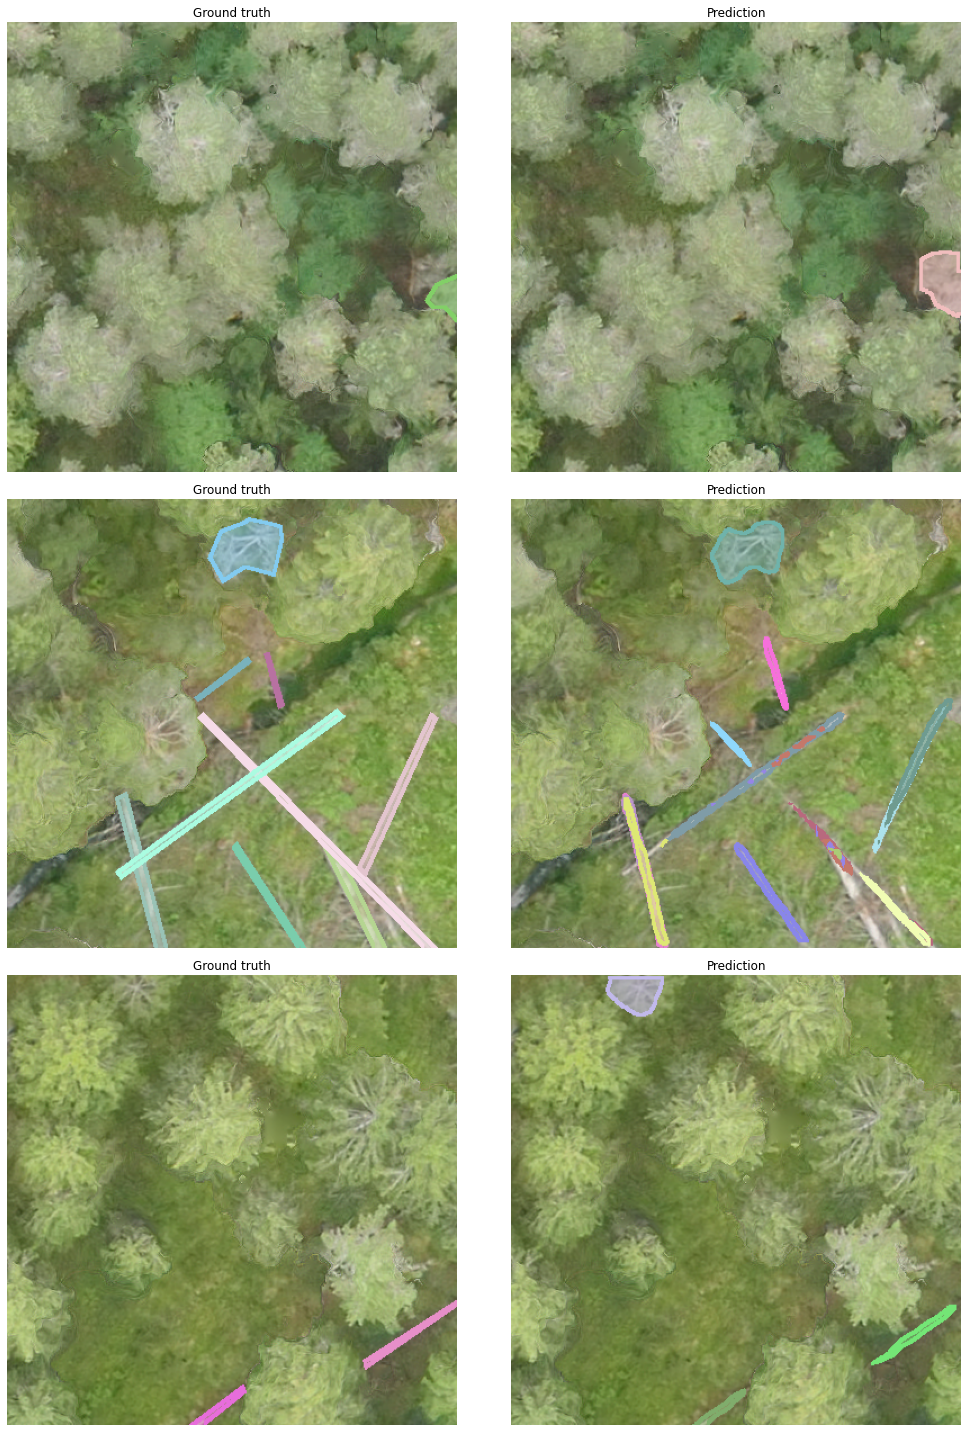

In [ ]:
ix = random.randint(0, len(samples)-3)
show_preds(
    samples=samples[ix:ix+3],
    preds=preds[ix:ix+3],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=2,
    display_label=False,
    display_bbox=False,
    figsize=(15,20)
)

In [ ]:
# TODO move these to drone_detector.visualizations?

def plot_grid_preds_actuals_raws(
    raws, actuals, predictions, figsize=None, show=False, annotations=None, **kwargs
):
    fig, axs = plt.subplots(
        nrows=len(actuals),
        ncols=3,
        figsize=figsize or (6, 6 * len(actuals) / 2 / 0.75),
        **kwargs,
    )
    i = 0
    for im, ax in zip(zip(raws, actuals, predictions), axs.reshape(-1, 3)):
        ax[0].imshow(im[0])
        ax[0].set_title('Aerial image')
        ax[1].imshow(im[1], cmap=None)
        ax[1].set_title("Expert annotations")
        ax[2].imshow(im[2], cmap=None)
        ax[2].set_title("Predicted annotations")

        if annotations is None:
            ax[0].set_axis_off()
            ax[1].set_axis_off()
            ax[2].set_axis_off()
        else:
            ax[0].set_axis_off()
            ax[1].get_xaxis().set_ticks([])
            ax[1].set_frame_on(False)
            ax[1].get_yaxis().set_visible(False)
            ax[1].set_xlabel(annotations[i][0], ma="left")

            ax[2].get_xaxis().set_ticks([])
            ax[2].set_frame_on(False)
            ax[2].get_yaxis().set_visible(False)
            ax[2].set_xlabel(annotations[i][1], ma="left")

            i += 1

    plt.tight_layout()
    if show:
        plt.show()
    return axs

def show_raw_mask_pred(    
    samples: Union[Sequence[np.ndarray], Sequence[dict]],
    preds: Sequence[dict],
    class_map: Optional[ClassMap] = None,
    denormalize_fn: Optional[callable] = denormalize_imagenet,
    display_label: bool = True,
    display_bbox: bool = True,
    display_mask: bool = True,
    ncols: int = 1,
    figsize=None,
    show=False,
    annotations=None,
) -> None:

    if not len(samples) == len(preds):
        raise ValueError(
            f"Number of imgs ({len(samples)}) should be the same as "
            f"the number of preds ({len(preds)})"
        )

    if all(type(x) is dict for x in samples):
        raws = [
            draw_sample(
                sample=sample,
                class_map=class_map,
                display_label=False,
                display_bbox=False,
                display_mask=False,
                denormalize_fn=denormalize_fn,
            )
            for sample in samples
        ]
        actuals = [
            draw_sample(
                sample=sample,
                class_map=class_map,
                display_label=display_label,
                display_bbox=display_bbox,
                display_mask=display_mask,
                denormalize_fn=denormalize_fn,
            )
            for sample in samples
        ]

        imgs = [sample["img"] for sample in samples]
        predictions = [
            draw_pred(
                img=img,
                pred=pred,
                class_map=class_map,
                denormalize_fn=denormalize_fn,
                display_label=display_label,
                display_bbox=display_bbox,
                display_mask=display_mask,
            )
            for img, pred in zip(imgs, preds)
        ]

        plot_grid_preds_actuals_raws(
            raws, actuals, predictions, figsize=figsize, show=show, annotations=annotations
        )

    else:
        partials = [
            partial(
                show_pred,
                img=img,
                pred=pred,
                class_map=class_map,
                denormalize_fn=denormalize_fn,
                display_label=display_label,
                display_bbox=display_bbox,
                display_mask=display_mask,
                show=False,
            )
            for img, pred in zip(samples, preds)
        ]
        plot_grid(
            partials, ncols=ncols, figsize=figsize, show=show, annotations=annotations
        )

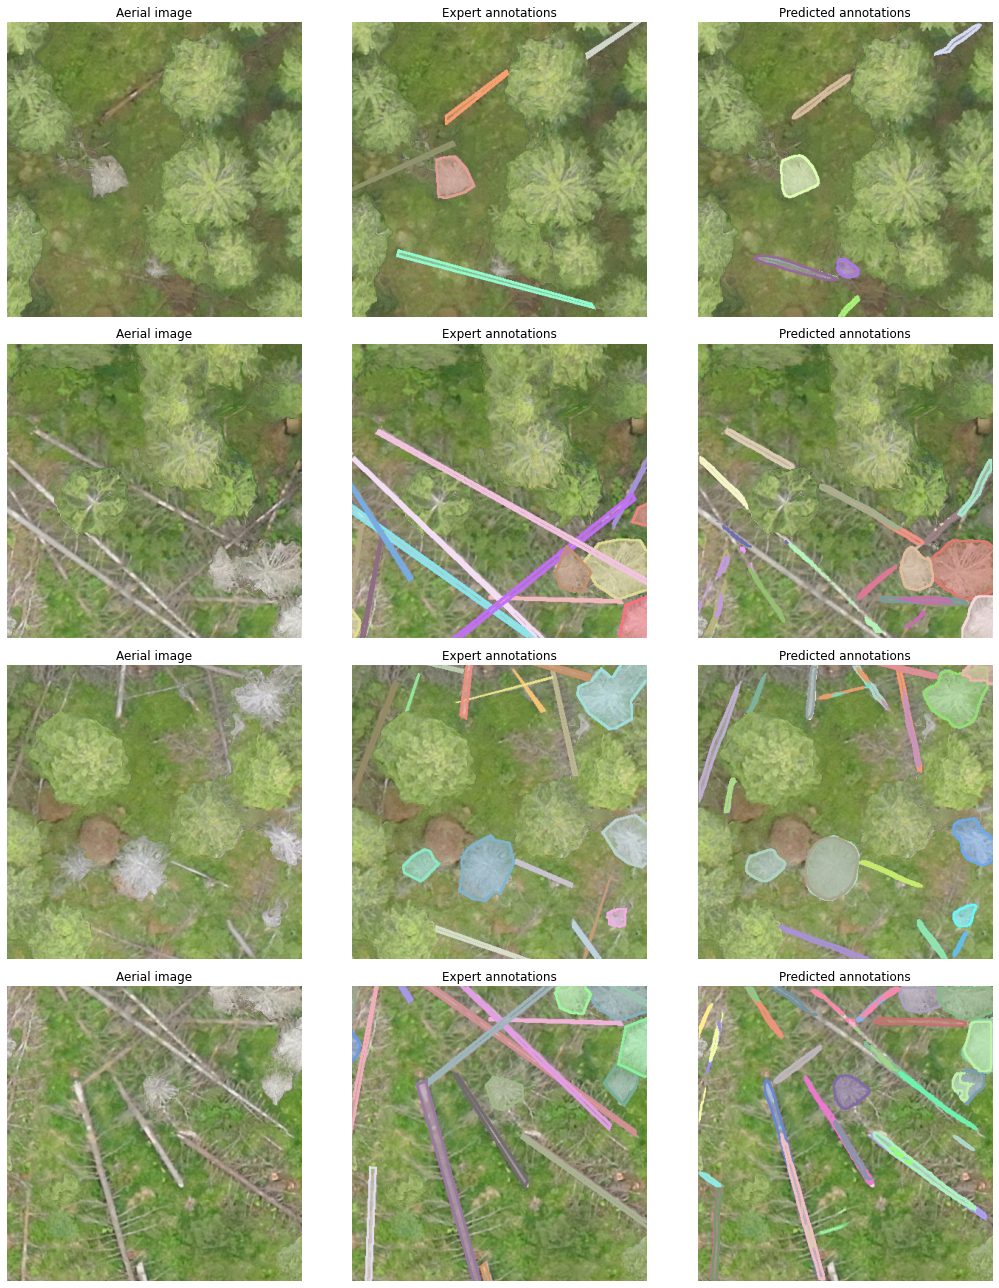

In [ ]:
ix = random.randint(0, len(samples)-4)
show_raw_mask_pred(
    samples=samples[ix:ix+4],
    preds=preds[ix:ix+4],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    ncols=3,
    display_label=False,
    display_bbox=False,
    figsize=(15,18)
)

# Tractor is difficult

In [ ]:
import PIL

img = np.array(PIL.Image.open('../../deadwood/data/tree_patches_deadwood_sudenpesankangas/R24C17.tif'))

<AxesSubplot:>

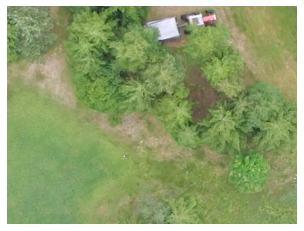

In [ ]:
show_img(img)

In [ ]:
infer_ds = Dataset.from_images([img], valid_tfms)
infer_dl = mask_rcnn.infer_dl(infer_ds, batch_size=1)
i_samples, i_preds = mask_rcnn.predict_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

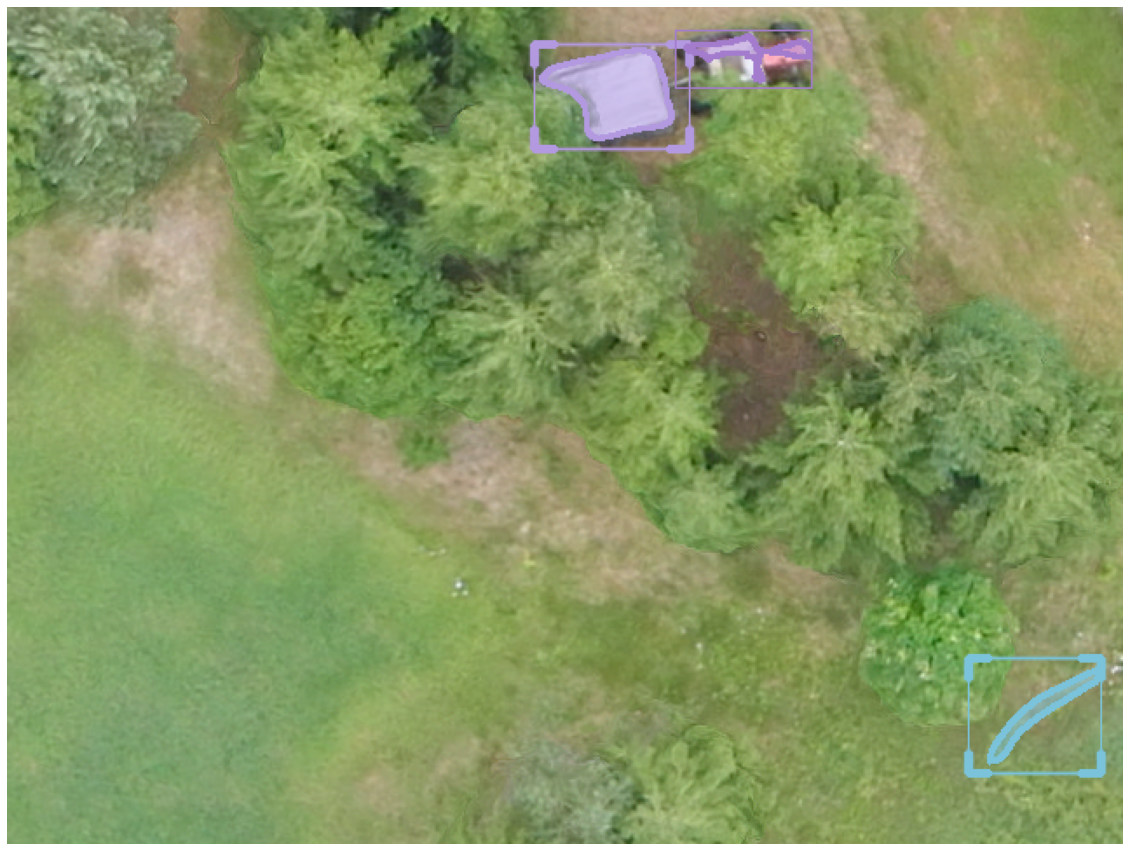

In [ ]:
fig, ax = plt.subplots(figsize=(20,18))
show_pred(
    i_samples[0]['img'],
    i_preds[0],
    class_map=class_map,
    denormalize_fn=denormalize_imagenet,
    display_label=False,
    display_bbox=True,
    ax=ax
)